In [1]:
import numpy as np
import pandas as pd

import re
!pip install emoji
import emoji
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv('gdrive/My Drive/Tweets.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
confidence_threshold = 0.6

data = data.drop(data.query("airline_sentiment_confidence < @confidence_threshold").index, axis=0).reset_index(drop=True)

In [5]:
tweets_df = pd.concat([data['text'], data['airline_sentiment']], axis=1)
tweets_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica I didn't today... Must mean I n...,neutral
2,@VirginAmerica it's really aggressive to blast...,negative
3,@VirginAmerica and it's a really big bad thing...,negative
4,@VirginAmerica seriously would pay $30 a fligh...,negative
...,...,...
14397,@AmericanAir right on cue with the delays👌,negative
14398,@AmericanAir leaving over 20 minutes Late Flig...,negative
14399,@AmericanAir Please bring American Airlines to...,neutral
14400,"@AmericanAir you have my money, you change my ...",negative


In [6]:
tweets_df.isna().sum().sum()

0

In [7]:
tweets_df['airline_sentiment'].value_counts()

negative    9113
neutral     2997
positive    2292
Name: airline_sentiment, dtype: int64

In [8]:
sentiment_ordering = ['negative', 'neutral', 'positive']

tweets_df['airline_sentiment'] = tweets_df['airline_sentiment'].apply(lambda x: sentiment_ordering.index(x))

In [9]:
tweets_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica I didn't today... Must mean I n...,1
2,@VirginAmerica it's really aggressive to blast...,0
3,@VirginAmerica and it's a really big bad thing...,0
4,@VirginAmerica seriously would pay $30 a fligh...,0
...,...,...
14397,@AmericanAir right on cue with the delays👌,0
14398,@AmericanAir leaving over 20 minutes Late Flig...,0
14399,@AmericanAir Please bring American Airlines to...,1
14400,"@AmericanAir you have my money, you change my ...",0


In [10]:
emoji.demojize('@AmericanAir right on cue with the delays👌')

'@AmericanAir right on cue with the delays:OK_hand:'

In [11]:
ps = PorterStemmer()

def process_tweet(tweet):
    new_tweet = tweet.lower()
    new_tweet = re.sub(r'@\w+', '', new_tweet) # Remove @s
    new_tweet = re.sub(r'#', '', new_tweet) # Remove hashtags
    new_tweet = re.sub(r':', ' ', emoji.demojize(new_tweet)) # Turn emojis into words
    new_tweet = re.sub(r'http\S+', '',new_tweet) # Remove URLs
    new_tweet = re.sub(r'\$\S+', 'dollar', new_tweet) # Change dollar amounts to dollar
    new_tweet = re.sub(r'[^a-z0-9\s]', '', new_tweet) # Remove punctuation
    new_tweet = re.sub(r'[0-9]+', 'number', new_tweet) # Change number values to number
    new_tweet = new_tweet.split(" ")
    new_tweet = list(map(lambda x: ps.stem(x), new_tweet)) # Stemming the words
    new_tweet = list(map(lambda x: x.strip(), new_tweet)) # Stripping whitespace from the words
    if '' in new_tweet:
        new_tweet.remove('')
    return new_tweet

In [12]:
tweets = tweets_df['text'].apply(process_tweet)

labels = np.array(tweets_df['airline_sentiment'])

In [13]:
tweets

0                                           [what, , said]
1        [i, didnt, today, must, mean, i, need, to, tak...
2        [it, realli, aggress, to, blast, obnoxi, enter...
3         [and, it, a, realli, big, bad, thing, about, it]
4        [serious, would, pay, dollar, a, flight, for, ...
                               ...                        
14397           [right, on, cue, with, the, delay, hand, ]
14398    [leav, over, number, minut, late, flight, no, ...
14399    [pleas, bring, american, airlin, to, blackberr...
14400    [you, have, my, money, you, chang, my, flight,...
14401    [we, have, number, ppl, so, we, need, number, ...
Name: text, Length: 14402, dtype: object

In [14]:
# Get size of vocabulary
vocabulary = set()

for tweet in tweets:
    for word in tweet:
        if word not in vocabulary:
            vocabulary.add(word)

vocab_length = len(vocabulary)

# Get max length of a sequence
max_seq_length = 0

for tweet in tweets:
    if len(tweet) > max_seq_length:
        max_seq_length = len(tweet)

# Print results
print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 11251
Max sequence length: 90


In [15]:
tokenizer = Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(tweets)

sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index

model_inputs = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [16]:
model_inputs

array([[  49,    2,  218, ...,    0,    0,    0],
       [   5,  191,  102, ...,    0,    0,    0],
       [  15,  138, 2841, ...,    0,    0,    0],
       ...,
       [  76,  507,  435, ...,    0,    0,    0],
       [   8,   19,   12, ...,    0,    0,    0],
       [  37,   19,    4, ...,    0,    0,    0]], dtype=int32)

In [17]:
model_inputs.shape

(14402, 90)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels, train_size=0.7, random_state=22)

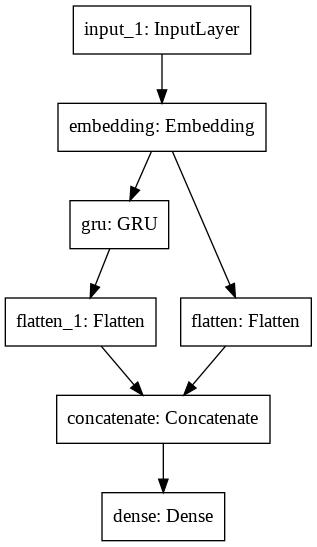

In [19]:
embedding_dim = 32


inputs = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(inputs)


# Model A (just a Flatten layer)
flatten = tf.keras.layers.Flatten()(embedding)

# Model B (GRU with a Flatten layer)
gru = tf.keras.layers.GRU(units=embedding_dim)(embedding)
gru_flatten = tf.keras.layers.Flatten()(gru)

# Both A and B are fed into the output
concat = tf.keras.layers.concatenate([flatten, gru_flatten])

outputs = tf.keras.layers.Dense(3, activation='softmax')(concat)


model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model)

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


batch_size = 32
epochs = 100

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/100
252/252 [==============================] - 11s 36ms/step - loss: 0.8793 - accuracy: 0.6207 - val_loss: 0.6628 - val_accuracy: 0.7229
Epoch 2/100
252/252 [==============================] - 8s 33ms/step - loss: 0.5421 - accuracy: 0.7844 - val_loss: 0.5376 - val_accuracy: 0.7858
Epoch 3/100
252/252 [==============================] - 8s 33ms/step - loss: 0.3713 - accuracy: 0.8713 - val_loss: 0.5062 - val_accuracy: 0.8027
Epoch 4/100
252/252 [==============================] - 8s 33ms/step - loss: 0.2696 - accuracy: 0.9172 - val_loss: 0.5089 - val_accuracy: 0.8052
Epoch 5/100
252/252 [==============================] - 8s 33ms/step - loss: 0.2044 - accuracy: 0.9395 - val_loss: 0.5265 - val_accuracy: 0.8032
Epoch 6/100
252/252 [==============================] - 8s 33ms/step - loss: 0.1547 - accuracy: 0.9601 - val_loss: 0.5490 - val_accuracy: 0.7982
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [21]:
y_train


array([0, 1, 0, ..., 0, 0, 0])

In [22]:
model.evaluate(X_test, y_test)

136/136 [==============================] - 1s 9ms/step - loss: 0.4848 - accuracy: 0.8037


[0.4848462641239166, 0.803749144077301]